# bitsandbytes

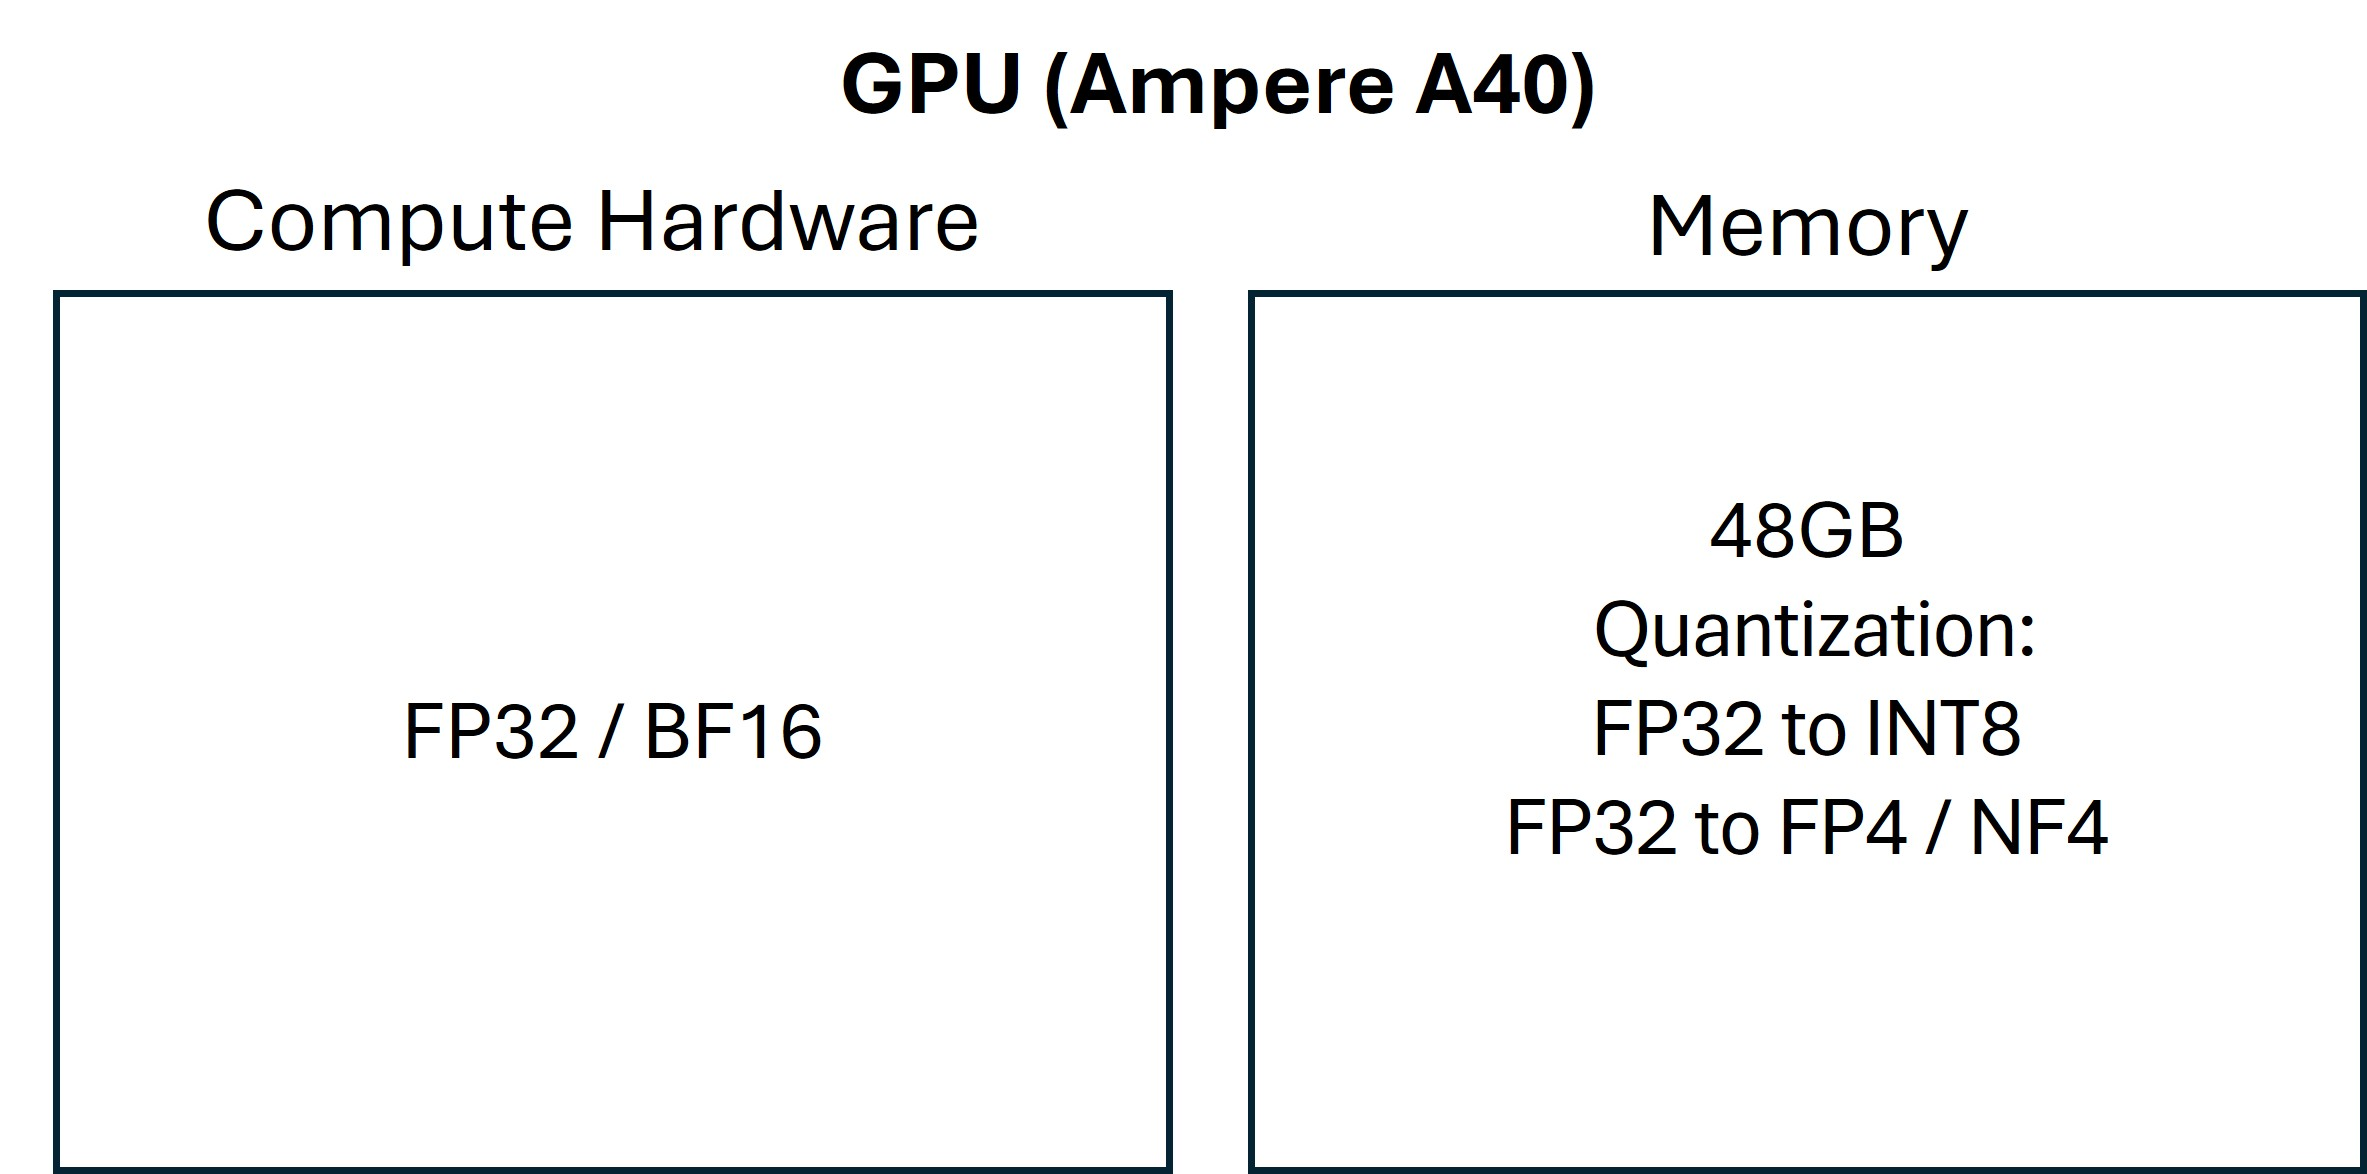

## Download requirements

First, install the dependencies below to get started. As these features are available on the `main` branches only, we need to install the libraries below from source.

In [1]:
# !pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Securely Load API Key
#os.environ["HF_TOKEN"] = ""

## Basic usage

Similarly as 8bit models, you can load and convert a model in 8bit by just adding the argument `load_in_4bit`! As simple as that!
Let's first try to load small models, by starting with `facebook/opt-350m`.

In [2]:
# Import libraries
from dotenv import load_dotenv
import os

load_dotenv()  # Make sure .env is in the same folder as this notebook
token = os.getenv("HUGGINGFACE_HUB_TOKEN")
assert token, "No HUGGINGFACE_HUB_TOKEN found in .env"

# ---- 2) Log in to Hugging Face ----
from huggingface_hub import login, whoami

login(token=token)  # Auth for this Python process
#print("HF user info:", whoami())  # Should print your username/orgs

from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "facebook/opt-350m"

model = AutoModelForCausalLM.from_pretrained(model_id, load_in_4bit=True, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_id)

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/662M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

The model conversion technique is totally similar as the one presented in the [8 bit integration blogpost](https://huggingface.co/blog/hf-bitsandbytes-integration) - it is based on module replacement. If you print the model, you will see that most of the `nn.Linear` layers are replaced by `bnb.nn.Linear4bit` layers!

In [3]:
print(model)

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear4bit(in_features=1024, out_features=512, bias=False)
      (project_in): Linear4bit(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear4bit(in_features=1024, out_features=4096, bias=True)
          (

Once loaded, run a prediction as you would do it with a classic model

In [4]:
text = "Hello my name is"
device = "cuda:0"

inputs = tokenizer(text, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Hello my name is jimmy and I am a new member of the reddit clan. I am a new member of


## Advaced usages

Let's review in this section advanced usage of the 4bit integration. First, you need to understand the different arguments that can be tweaked and used.

All these parameters can be changed by using the `BitsandBytesConfig` from `transformers` and pass it to `quantization_config` argument when calling `from_pretrained`.

Make sure to pass `load_in_4bit=True` when using the `BitsAndBytesConfig`!

### Changing the compute dtype

The compute dtype is used to change the dtype that will be used during computation. For example, hidden states could be in `float32` but computation can be set to `bf16` for speedups.
By default, the compute dtype is set to `float32`.


In [5]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [6]:
model_cd_bf16 = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)

In [7]:
outputs = model_cd_bf16.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Hello my name is jimmy and I am a new member of the reddit clan. I am a new member of


### Changing the quantization type

The 4bit integration comes with 2 different quantization types: FP4 and NF4. The NF4 dtype stands for Normal Float 4 and is introduced in the [QLoRA paper](https://arxiv.org/abs/2305.14314)

YOu can switch between these two dtype using `bnb_4bit_quant_type` from `BitsAndBytesConfig`. By default, the FP4 quantization is used.

In [8]:
from transformers import BitsAndBytesConfig

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
)

model_nf4 = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=nf4_config)

In [9]:
outputs = model_nf4.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Hello my name is John and I am a very happy man. I am a very happy man. I am a very


### Combining all the features together

Of course, the features are not mutually exclusive. You can combine these features together inside a single quantization config. Let us assume you want to run a model with `nf4` as the quantization type, with nested quantization and using `bfloat16` as the compute dtype:

In [10]:
import torch
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_4bit = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config)

In [11]:
outputs = model_4bit.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Hello my name is John and I am a very happy man. I am a very happy man. I am a very


## Pushing the limits of Quantization

How far can we go using 4bit quantization? We'll see below that it is possible to load a 20B-scale model (40GB in half precision) entirely on the GPU using this quantization method! 🤯

Let's load the model with NF4 quantization type for better results, `bfloat16` compute dtype as well as nested quantization for a more memory efficient model loading.

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "EleutherAI/gpt-neox-20b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model_4bit = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

tokenizer_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 46 files:   0%|          | 0/46 [00:00<?, ?it/s]

model-00003-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00001-of-00046.safetensors:   0%|          | 0.00/926M [00:00<?, ?B/s]

model-00005-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00004-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00002-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00007-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00006-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00008-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00009-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00010-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00011-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00012-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00013-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00014-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00015-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00016-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00017-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00018-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00019-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00020-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00021-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00022-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00023-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00024-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00025-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00026-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00027-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00028-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00029-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00030-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00031-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00032-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00033-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00034-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00035-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00036-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00037-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00038-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00039-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00040-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00041-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00042-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00043-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00044-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00045-of-00046.safetensors:   0%|          | 0.00/604M [00:00<?, ?B/s]

model-00046-of-00046.safetensors:   0%|          | 0.00/620M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/46 [00:00<?, ?it/s]

Let's make sure we loaded the whole model on GPU

In [13]:
model_4bit.hf_device_map

{'': 0}

Once loaded, run a generation!

In [14]:
text = "Hello my name is"
device = "cuda:0"
inputs = tokenizer(text, return_tensors="pt").to(device)

outputs = model_4bit.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Hello my name is john and i am a student at the university of

i am a student at the university


As you can see, we were able to load and run the 4bit gpt-neo-x model entirely on the GPU

# Push Model to HuggingFace

In [15]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "facebook/opt-350m"

model = AutoModelForCausalLM.from_pretrained(model_id, load_in_4bit=True, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_id)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [16]:
# Define model and repo details
model_name = "maven-opt-350m-4bit-rlai"  # Change to your desired model name
repo_name = f"richlai/{model_name}"  # Change 'your_username' to your HF username

# Push to Hugging Face
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpn8h3gt3g/model.safetensors    :  11%|#1        | 25.1MB /  227MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/richlai/maven-opt-350m-4bit-rlai/commit/77f83e9e566e8117054eeee11a5cc92d76b010f5', commit_message='Upload tokenizer', commit_description='', oid='77f83e9e566e8117054eeee11a5cc92d76b010f5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/richlai/maven-opt-350m-4bit-rlai', endpoint='https://huggingface.co', repo_type='model', repo_id='richlai/maven-opt-350m-4bit-rlai'), pr_revision=None, pr_num=None)